In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (10,99)
NUM2_RANGE = (10,99)
TRAINING_SAMPLE_SIZE = 100
TEST_SAMPLE_SIZE = 10
TRAINING_EPOCH = 20

### Transformer for Calculation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [7]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-4 #1e-3
EPOCHS = TRAINING_EPOCH

In [8]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [9]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_enc = nn.Embedding(max_len, embed_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, 
            nhead=num_heads, 
            bias=False,
            activation='gelu',
            batch_first=True,)
        
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.pos = torch.arange(0, max_len, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    def forward(self, src):
        batch_size, seq_len = src.shape
        tok_emb = self.token_emb(src)  # (batch=1, seq_len, emb_dim)
        pos_emb = self.pos_enc(self.pos)[:,:seq_len,:]
        x = self.dropout(tok_emb + pos_emb)
        memory = torch.zeros_like(x)  # No encoder output
        output = self.transformer_decoder(x, memory)
        return self.fc_out(output)

In [10]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=4)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 6))

    pc_axes = [[0,1],[2,3]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(1, len(pc_axes), plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png',
                    bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [11]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

e:\teaching_arithmetic_replication\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [13]:
model = model.to(device)

In [14]:
data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'Embedding PCA (Epoch:0, Loss:N/A)')

  9%|▉         | 9/100 [00:01<00:07, 11.82it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['7', '4']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['7', '7', '7']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['4', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['4', '7', '7']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['7', '7']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['7', '7', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['8', '7', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['1', '1', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '7']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '1']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['8', '8', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['8', '1', '1']
sentence:  82

 24%|██▍       | 24/100 [00:01<00:02, 31.50it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['8', '8']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['8', '2', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['8', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['8', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['8', '0', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['4', '6']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['6', '6', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['6', '6', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['6', '6']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['4', '0', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['4', '6']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['4', '1', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['4', '1']
sentence:  93+77=611
tar

 40%|████      | 40/100 [00:01<00:01, 48.19it/s]

sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['1', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['1', '1', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['1', '1', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['8', '1', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['8', '1']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['8', '8']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['8', '1']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['8', '8']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['8', '8', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['8', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['4', '9']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['7', '9']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['8', '7']
sentence:  95+23=19
target_char:  [

 55%|█████▌    | 55/100 [00:01<00:00, 58.31it/s]

sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '9', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['3', '9', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['3', '9', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['3', '9']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['3', '3', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['3', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '3', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['3', '3']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '3', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['0', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['0', '2']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['0', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['

 69%|██████▉   | 69/100 [00:01<00:00, 61.08it/s]

sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['0', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['6', '6']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['0', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['6', '9']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['6', '9', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '9', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['9', '9']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['6', '0', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '6']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '6']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['6', '6']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['6', '6']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['6', '7']
sentence:  06+23=29
target_char:  [

 91%|█████████ | 91/100 [00:02<00:00, 65.57it/s]

sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['4', '4', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '7']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '7', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '0', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['3', '3', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '2']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['3', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '1', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '0', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_cha

100%|██████████| 100/100 [00:02<00:00, 42.74it/s]


sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['4', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '7', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '7', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '7']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '7', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '7']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '9', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 1, Loss: 171.64616918563843


 14%|█▍        | 14/100 [00:00<00:01, 68.24it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '6']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '8', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '9']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '7']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['8', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 67.20it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '9']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '1']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '6', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '5']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '6']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '6']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '6', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '8']
sentence:  93+77=611
tar

 37%|███▋      | 37/100 [00:00<00:00, 70.36it/s]

sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '7']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '8']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '9']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '9']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '9']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '5']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '9']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '4']
sentence:  61+71=33
target_char:  [

 52%|█████▏    | 52/100 [00:00<00:00, 65.38it/s]

sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '7']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '4']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '9']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '8']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '4']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']


 66%|██████▌   | 66/100 [00:01<00:00, 59.69it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '8']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '8']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '6']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '9']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '9']


 73%|███████▎  | 73/100 [00:01<00:00, 59.80it/s]

sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '6']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '9']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '9']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '6']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']


 94%|█████████▍| 94/100 [00:01<00:00, 64.41it/s]

sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '9']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '9']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '7']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
se

100%|██████████| 100/100 [00:01<00:00, 64.16it/s]


sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '7']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '7']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 2, Loss: 128.1409536600113


  7%|▋         | 7/100 [00:00<00:01, 67.24it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '6']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '7']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '7']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 22%|██▏       | 22/100 [00:00<00:01, 66.09it/s]

sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '9']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '8']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '8']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']


 36%|███▌      | 36/100 [00:00<00:00, 65.05it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '8']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '9']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '6']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '5']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '9']
sentence:  15+11=26
targ

 50%|█████     | 50/100 [00:00<00:00, 63.85it/s]

sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '7']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '9']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '7']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']


 64%|██████▍   | 64/100 [00:01<00:00, 60.75it/s]

sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '9']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '8']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '4']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '2']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']


 78%|███████▊  | 78/100 [00:01<00:00, 60.26it/s]

sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '9']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '6']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '7']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '9']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '9']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']


 85%|████████▌ | 85/100 [00:01<00:00, 58.99it/s]

sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '9']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '9']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']


100%|██████████| 100/100 [00:01<00:00, 63.02it/s]

sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '7']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '9']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '7']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 3, Loss: 121.15929341316223



 14%|█▍        | 14/100 [00:00<00:01, 66.28it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '6']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '6']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '7']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '7']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 67.60it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '4']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '9']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '6']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '8']
sentence:  93+77=611
tar

 36%|███▌      | 36/100 [00:00<00:00, 67.24it/s]

sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '9']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '9']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '1']
sentence:  61+71=33
target_char:  [

 51%|█████     | 51/100 [00:00<00:00, 64.37it/s]

sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '9']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '6']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']


 64%|██████▍   | 64/100 [00:01<00:00, 56.44it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '4']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']


 76%|███████▌  | 76/100 [00:01<00:00, 54.04it/s]

sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '6']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '6']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '6']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '6']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']


 88%|████████▊ | 88/100 [00:01<00:00, 54.67it/s]

sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '3']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '9']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '1', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '7']


100%|██████████| 100/100 [00:01<00:00, 60.77it/s]


sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '4']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 4, Loss: 118.39226794242859


  5%|▌         | 5/100 [00:00<00:02, 46.26it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '7']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '7']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']


 26%|██▌       | 26/100 [00:00<00:01, 65.49it/s]

sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '9']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '6']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
tar

 33%|███▎      | 33/100 [00:00<00:01, 62.22it/s]

sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '8']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']


 46%|████▌     | 46/100 [00:00<00:00, 55.55it/s]

sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '5']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '7']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '8']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']


 58%|█████▊    | 58/100 [00:01<00:00, 55.38it/s]

sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '1']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '8']


 71%|███████   | 71/100 [00:01<00:00, 58.50it/s]

sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '2']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '6']
sentence:  25+23=48
target_char:  [

 85%|████████▌ | 85/100 [00:01<00:00, 60.31it/s]

sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '6']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '2', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '9']


 99%|█████████▉| 99/100 [00:01<00:00, 63.83it/s]

sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '7']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '7']
se

100%|██████████| 100/100 [00:01<00:00, 60.10it/s]


sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 5, Loss: 115.47311496734619


 12%|█▏        | 12/100 [00:00<00:01, 57.40it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '0', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']


 18%|█▊        | 18/100 [00:00<00:01, 53.65it/s]

sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '8']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']


 30%|███       | 30/100 [00:00<00:01, 52.77it/s]

sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']


 42%|████▏     | 42/100 [00:00<00:01, 52.00it/s]

sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']


 55%|█████▌    | 55/100 [00:01<00:00, 55.51it/s]

sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '9']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '7']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']


 61%|██████    | 61/100 [00:01<00:00, 51.44it/s]

sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']


 72%|███████▏  | 72/100 [00:01<00:00, 47.93it/s]

sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '6']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']


 85%|████████▌ | 85/100 [00:01<00:00, 55.62it/s]

sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_cha

100%|██████████| 100/100 [00:01<00:00, 53.10it/s]

sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 6, Loss: 112.08616995811462



  6%|▌         | 6/100 [00:00<00:01, 57.68it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '9']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']


 20%|██        | 20/100 [00:00<00:01, 58.55it/s]

sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '7']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '3']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '6']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']


 34%|███▍      | 34/100 [00:00<00:01, 61.65it/s]

sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '8']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '9']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11

 48%|████▊     | 48/100 [00:00<00:00, 63.83it/s]

sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '6']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '4']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '3']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
tar

 62%|██████▏   | 62/100 [00:00<00:00, 64.69it/s]

sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
tar

 76%|███████▌  | 76/100 [00:01<00:00, 65.95it/s]

sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '9']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']


 90%|█████████ | 90/100 [00:01<00:00, 65.64it/s]

sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '

100%|██████████| 100/100 [00:01<00:00, 64.12it/s]


sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 7, Loss: 112.61236047744751


  7%|▋         | 7/100 [00:00<00:01, 65.10it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']


 21%|██        | 21/100 [00:00<00:01, 65.11it/s]

sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
targ

 35%|███▌      | 35/100 [00:00<00:00, 66.16it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
targ

 50%|█████     | 50/100 [00:00<00:00, 65.59it/s]

sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52

 64%|██████▍   | 64/100 [00:00<00:00, 65.61it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
targ

 78%|███████▊  | 78/100 [00:01<00:00, 67.16it/s]

sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98

 92%|█████████▏| 92/100 [00:01<00:00, 65.27it/s]

sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
se

100%|██████████| 100/100 [00:01<00:00, 65.56it/s]


sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 8, Loss: 108.74863338470459


 16%|█▌        | 16/100 [00:00<00:01, 76.68it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '9']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 24%|██▍       | 24/100 [00:00<00:01, 75.62it/s]

sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51

 40%|████      | 40/100 [00:00<00:00, 71.39it/s]

sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  [

 56%|█████▌    | 56/100 [00:00<00:00, 70.45it/s]

sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['

 72%|███████▏  | 72/100 [00:01<00:00, 70.61it/s]

sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', 

 87%|████████▋ | 87/100 [00:01<00:00, 68.96it/s]

sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_cha

100%|██████████| 100/100 [00:01<00:00, 70.29it/s]


sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 9, Loss: 109.71349632740021


 14%|█▍        | 14/100 [00:00<00:01, 66.34it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 66.76it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
tar

 35%|███▌      | 35/100 [00:00<00:01, 62.86it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']


 49%|████▉     | 49/100 [00:00<00:00, 64.23it/s]

sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
targ

 63%|██████▎   | 63/100 [00:00<00:00, 64.82it/s]

sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22

 78%|███████▊  | 78/100 [00:01<00:00, 67.13it/s]

sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
tar

 99%|█████████▉| 99/100 [00:01<00:00, 68.28it/s]

sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
se

100%|██████████| 100/100 [00:01<00:00, 66.23it/s]


sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 10, Loss: 108.29170155525208


  7%|▋         | 7/100 [00:00<00:01, 64.21it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 22%|██▏       | 22/100 [00:00<00:01, 67.90it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
tar

 36%|███▌      | 36/100 [00:00<00:00, 67.55it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
targ

 50%|█████     | 50/100 [00:00<00:00, 66.12it/s]

sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52

 64%|██████▍   | 64/100 [00:00<00:00, 64.45it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
targ

 78%|███████▊  | 78/100 [00:01<00:00, 64.19it/s]

sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98

 94%|█████████▍| 94/100 [00:01<00:00, 67.60it/s]

sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
se

100%|██████████| 100/100 [00:01<00:00, 66.44it/s]


sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 11, Loss: 108.23305344581604


  7%|▋         | 7/100 [00:00<00:01, 66.00it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 22%|██▏       | 22/100 [00:00<00:01, 65.29it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
tar

 36%|███▌      | 36/100 [00:00<00:01, 62.05it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']


 50%|█████     | 50/100 [00:00<00:00, 62.94it/s]

sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
tar

 64%|██████▍   | 64/100 [00:01<00:00, 62.55it/s]

sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
tar

 78%|███████▊  | 78/100 [00:01<00:00, 62.36it/s]

sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
tar

 92%|█████████▏| 92/100 [00:01<00:00, 64.95it/s]

sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']


100%|██████████| 100/100 [00:01<00:00, 63.17it/s]


sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 12, Loss: 108.19386231899261


  6%|▌         | 6/100 [00:00<00:01, 53.32it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']


 18%|█▊        | 18/100 [00:00<00:01, 56.76it/s]

sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']


 32%|███▏      | 32/100 [00:00<00:01, 60.38it/s]

sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11

 46%|████▌     | 46/100 [00:00<00:00, 60.89it/s]

sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']


 60%|██████    | 60/100 [00:01<00:00, 59.44it/s]

sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']


 74%|███████▍  | 74/100 [00:01<00:00, 61.93it/s]

sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']


 88%|████████▊ | 88/100 [00:01<00:00, 63.71it/s]

sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_cha

100%|██████████| 100/100 [00:01<00:00, 60.63it/s]


sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 13, Loss: 108.18496751785278


  7%|▋         | 7/100 [00:00<00:01, 66.32it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 62.41it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']


 35%|███▌      | 35/100 [00:00<00:01, 61.48it/s]

sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']


 49%|████▉     | 49/100 [00:00<00:00, 58.73it/s]

sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']


 62%|██████▏   | 62/100 [00:01<00:00, 59.15it/s]

sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']


 75%|███████▌  | 75/100 [00:01<00:00, 60.10it/s]

sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']


 89%|████████▉ | 89/100 [00:01<00:00, 63.26it/s]

sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_cha

100%|██████████| 100/100 [00:01<00:00, 61.64it/s]


sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 14, Loss: 108.20908379554749


 14%|█▍        | 14/100 [00:00<00:01, 68.54it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 28%|██▊       | 28/100 [00:00<00:01, 64.75it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
tar

 42%|████▏     | 42/100 [00:00<00:00, 65.92it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
targ

 49%|████▉     | 49/100 [00:00<00:00, 64.92it/s]

sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52

 70%|███████   | 70/100 [00:01<00:00, 65.95it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
targ

 84%|████████▍ | 84/100 [00:01<00:00, 67.45it/s]

sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98

 91%|█████████ | 91/100 [00:01<00:00, 67.50it/s]

sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
se

100%|██████████| 100/100 [00:01<00:00, 66.63it/s]


sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 15, Loss: 108.1618024110794


  5%|▌         | 5/100 [00:00<00:01, 49.42it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']


 20%|██        | 20/100 [00:00<00:01, 59.99it/s]

sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']


 34%|███▍      | 34/100 [00:00<00:01, 63.16it/s]

sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
tar

 49%|████▉     | 49/100 [00:00<00:00, 66.18it/s]

sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
tar

 63%|██████▎   | 63/100 [00:00<00:00, 63.34it/s]

sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']


 77%|███████▋  | 77/100 [00:01<00:00, 65.46it/s]

sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
tar

 99%|█████████▉| 99/100 [00:01<00:00, 69.50it/s]

sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
se

100%|██████████| 100/100 [00:01<00:00, 65.42it/s]


sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 16, Loss: 108.15299308300018


  7%|▋         | 7/100 [00:00<00:01, 65.41it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 64.07it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
tar

 36%|███▌      | 36/100 [00:00<00:00, 67.60it/s]

sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
targ

 51%|█████     | 51/100 [00:00<00:00, 68.12it/s]

sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
se

 66%|██████▌   | 66/100 [00:00<00:00, 66.01it/s]

sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']


 80%|████████  | 80/100 [00:01<00:00, 63.99it/s]

sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']


 94%|█████████▍| 94/100 [00:01<00:00, 63.61it/s]

sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '

100%|██████████| 100/100 [00:01<00:00, 65.61it/s]


sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 17, Loss: 108.14754259586334


  7%|▋         | 7/100 [00:00<00:01, 61.91it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']


 21%|██        | 21/100 [00:00<00:01, 59.38it/s]

sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
tar

 35%|███▌      | 35/100 [00:00<00:01, 60.89it/s]

sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']


 49%|████▉     | 49/100 [00:00<00:00, 61.27it/s]

sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']


 63%|██████▎   | 63/100 [00:01<00:00, 61.70it/s]

sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']


 70%|███████   | 70/100 [00:01<00:00, 61.60it/s]

sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']


 84%|████████▍ | 84/100 [00:01<00:00, 62.22it/s]

sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_cha

100%|██████████| 100/100 [00:01<00:00, 61.74it/s]

sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 18, Loss: 108.14410591125488



  7%|▋         | 7/100 [00:00<00:01, 64.07it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']


 21%|██        | 21/100 [00:00<00:01, 60.68it/s]

sentence:  82+63=46
target_char:  ['4', '6']
output_char:  ['4', '6']
sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']


 35%|███▌      | 35/100 [00:00<00:01, 62.37it/s]

sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']


 49%|████▉     | 49/100 [00:00<00:00, 62.17it/s]

sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03+95=98
target_char:  ['9', '8']
output_char:  ['9', '8']
sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
tar

 63%|██████▎   | 63/100 [00:01<00:00, 61.34it/s]

sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']


 77%|███████▋  | 77/100 [00:01<00:00, 62.67it/s]

sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']
sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
tar

 91%|█████████ | 91/100 [00:01<00:00, 61.48it/s]

sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
se

100%|██████████| 100/100 [00:01<00:00, 61.64it/s]


sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '1', '1']
sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 19, Loss: 108.1426522731781


 14%|█▍        | 14/100 [00:00<00:01, 66.84it/s]

sentence:  36+11=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  84+75=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  43+44=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  28+56=741
target_char:  ['7', '4', '1']
output_char:  ['7', '4', '1']
sentence:  03+75=78
target_char:  ['7', '8']
output_char:  ['7', '8']
sentence:  52+56=09
target_char:  ['0', '9']
output_char:  ['0', '9']
sentence:  34+18=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  09+23=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  88+08=861
target_char:  ['8', '6', '1']
output_char:  ['8', '6', '1']
sentence:  33+55=88
target_char:  ['8', '8']
output_char:  ['8', '8']
sentence:  12+77=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  26+48=641
target_char:  ['6', '4', '1']
output_char:  ['6', '4', '1']
sentence:  47+13=501
target_char:  ['5', '0', '1']
output_char:  ['5', '0', '1']
sentence:  82

 21%|██        | 21/100 [00:00<00:01, 66.32it/s]

sentence:  91+43=35
target_char:  ['3', '5']
output_char:  ['3', '5']
sentence:  35+15=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  31+86=18
target_char:  ['1', '8']
output_char:  ['1', '8']
sentence:  35+31=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+01=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  01+49=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  03+48=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  23+64=87
target_char:  ['8', '7']
output_char:  ['8', '7']
sentence:  22+39=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  36+32=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  79+38=081
target_char:  ['0', '8', '1']
output_char:  ['0', '8', '1']
sentence:  33+85=19
target_char:  ['1', '9']
output_char:  ['1', '9']


 35%|███▌      | 35/100 [00:00<00:01, 62.33it/s]

sentence:  93+77=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  68+25=831
target_char:  ['8', '3', '1']
output_char:  ['8', '3', '1']
sentence:  51+93=45
target_char:  ['4', '5']
output_char:  ['4', '5']
sentence:  52+37=89
target_char:  ['8', '9']
output_char:  ['8', '9']
sentence:  73+18=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
sentence:  59+33=821
target_char:  ['8', '2', '1']
output_char:  ['8', '2', '1']
sentence:  24+58=721
target_char:  ['7', '2', '1']
output_char:  ['7', '2', '1']
sentence:  56+67=141
target_char:  ['1', '4', '1']
output_char:  ['1', '4', '1']
sentence:  62+51=14
target_char:  ['1', '4']
output_char:  ['1', '4']
sentence:  13+84=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  11+92=04
target_char:  ['0', '4']
output_char:  ['0', '4']
sentence:  93+45=39
target_char:  ['3', '9']
output_char:  ['3', '9']
sentence:  97+35=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  03

 49%|████▉     | 49/100 [00:00<00:00, 62.78it/s]

sentence:  15+11=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  61+71=33
target_char:  ['3', '3']
output_char:  ['3', '3']
sentence:  66+02=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  95+23=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  11+75=86
target_char:  ['8', '6']
output_char:  ['8', '6']
sentence:  73+69=331
target_char:  ['3', '3', '1']
output_char:  ['3', '3', '1']
sentence:  57+52=001
target_char:  ['0', '0', '1']
output_char:  ['0', '0', '1']
sentence:  17+98=061
target_char:  ['0', '6', '1']
output_char:  ['0', '6', '1']
sentence:  71+11=82
target_char:  ['8', '2']
output_char:  ['8', '2']
sentence:  09+27=261
target_char:  ['2', '6', '1']
output_char:  ['2', '6', '1']
sentence:  15+88=931
target_char:  ['9', '3', '1']
output_char:  ['9', '3', '1']
sentence:  36+08=341
target_char:  ['3', '4', '1']
output_char:  ['3', '4', '1']
sentence:  53+65=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  49+99=391
tar

 63%|██████▎   | 63/100 [00:00<00:00, 63.03it/s]

sentence:  52+18=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  92+02=94
target_char:  ['9', '4']
output_char:  ['9', '4']
sentence:  37+13=401
target_char:  ['4', '0', '1']
output_char:  ['4', '0', '1']
sentence:  25+93=19
target_char:  ['1', '9']
output_char:  ['1', '9']
sentence:  63+03=66
target_char:  ['6', '6']
output_char:  ['6', '6']
sentence:  03+64=67
target_char:  ['6', '7']
output_char:  ['6', '7']
sentence:  92+87=701
target_char:  ['7', '0', '1']
output_char:  ['7', '0', '1']
sentence:  12+67=79
target_char:  ['7', '9']
output_char:  ['7', '9']
sentence:  99+01=901
target_char:  ['9', '0', '1']
output_char:  ['9', '0', '1']
sentence:  82+01=83
target_char:  ['8', '3']
output_char:  ['8', '3']
sentence:  49+37=761
target_char:  ['7', '6', '1']
output_char:  ['7', '6', '1']
sentence:  33+78=021
target_char:  ['0', '2', '1']
output_char:  ['0', '2', '1']
sentence:  22+34=56
target_char:  ['5', '6']
output_char:  ['5', '6']


 77%|███████▋  | 77/100 [00:01<00:00, 63.21it/s]

sentence:  47+16=531
target_char:  ['5', '3', '1']
output_char:  ['5', '3', '1']
sentence:  81+86=68
target_char:  ['6', '8']
output_char:  ['6', '8']
sentence:  36+33=69
target_char:  ['6', '9']
output_char:  ['6', '9']
sentence:  14+33=47
target_char:  ['4', '7']
output_char:  ['4', '7']
sentence:  31+75=07
target_char:  ['0', '7']
output_char:  ['0', '7']
sentence:  25+23=48
target_char:  ['4', '8']
output_char:  ['4', '8']
sentence:  06+23=29
target_char:  ['2', '9']
output_char:  ['2', '9']
sentence:  23+38=511
target_char:  ['5', '1', '1']
output_char:  ['5', '1', '1']
sentence:  79+67=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  14+26=301
target_char:  ['3', '0', '1']
output_char:  ['3', '0', '1']
sentence:  57+89=371
target_char:  ['3', '7', '1']
output_char:  ['3', '7', '1']
sentence:  36+15=411
target_char:  ['4', '1', '1']
output_char:  ['4', '1', '1']
sentence:  52+81=34
target_char:  ['3', '4']
output_char:  ['3', '4']
sentence:  29+86=061
tar

 91%|█████████ | 91/100 [00:01<00:00, 62.51it/s]

sentence:  43+09=421
target_char:  ['4', '2', '1']
output_char:  ['4', '2', '1']
sentence:  98+38=271
target_char:  ['2', '7', '1']
output_char:  ['2', '7', '1']
sentence:  53+72=26
target_char:  ['2', '6']
output_char:  ['2', '6']
sentence:  77+93=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  25+28=431
target_char:  ['4', '3', '1']
output_char:  ['4', '3', '1']
sentence:  74+62=37
target_char:  ['3', '7']
output_char:  ['3', '7']
sentence:  87+57=351
target_char:  ['3', '5', '1']
output_char:  ['3', '5', '1']
sentence:  89+59=391
target_char:  ['3', '9', '1']
output_char:  ['3', '9', '1']
sentence:  71+34=06
target_char:  ['0', '6']
output_char:  ['0', '6']
sentence:  46+51=97
target_char:  ['9', '7']
output_char:  ['9', '7']
sentence:  65+67=231
target_char:  ['2', '3', '1']
output_char:  ['2', '3', '1']
sentence:  87+38=161
target_char:  ['1', '6', '1']
output_char:  ['1', '6', '1']
sentence:  32+09=311
target_char:  ['3', '1', '1']
output_char:  ['3', '

100%|██████████| 100/100 [00:01<00:00, 62.85it/s]


sentence:  81+92=74
target_char:  ['7', '4']
output_char:  ['7', '4']
sentence:  75+19=841
target_char:  ['8', '4', '1']
output_char:  ['8', '4', '1']
sentence:  41+54=95
target_char:  ['9', '5']
output_char:  ['9', '5']
sentence:  66+79=361
target_char:  ['3', '6', '1']
output_char:  ['3', '6', '1']
sentence:  75+16=811
target_char:  ['8', '1', '1']
output_char:  ['8', '1', '1']
Epoch 20, Loss: 108.13719856739044


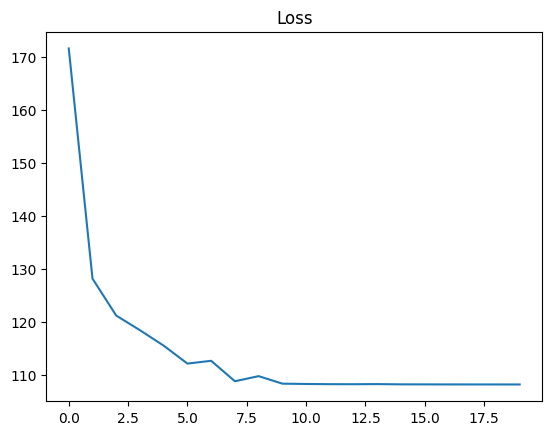

In [15]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            print('sentence: ', data)
            print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
            print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

            if True:
                loss.backward()
                optimizer.step()
            else:
                scaler = torch.cuda.amp.GradScaler(enabled=True)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
    losses.append(epoch_loss/len(batch))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'Embedding PCA (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

In [16]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  94+76=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  88+34=131
target_char:  ['1', '3', '1']
output_char:  ['1', '3', '1']
sentence:  94+37=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  17+61=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  34+76=011
target_char:  ['0', '1', '1']
output_char:  ['0', '1', '1']
sentence:  31+83=15
target_char:  ['1', '5']
output_char:  ['1', '9']
sentence:  45+72=18
target_char:  ['1', '8']
output_char:  ['1', '9']
sentence:  01+69=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  09+02=011
target_char:  ['0', '1', '1']
output_char:  ['0', '1', '1']
sentence:  31+42=73
target_char:  ['7', '3']
output_char:  ['7', '4']


In [17]:
print("Accuracy: ", accuracy)

Accuracy:  0.8461538461538461
